# Wildfire Analysis

First things first: Imports.

In [ ]:
# In order to be able to read parquet files
# !pip install pyarrow

In [90]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import breakdown
import preprocess

sns.set(context='notebook', rc={'figure.figsize':(10, 8)})

## Load the wildfire training data

Let's read in the training data from its home in my AFS www directory. This can take a bit of time (30s to a minute or so).

In [ ]:
FILE = '../../finalproject/wildfires-shuffled.parquet'
(X_train, Y_train), (X_test, Y_test) = preprocess.load_dataset(FILE)

At this point, it's interesting to see the distribution of the remaining causes. Note that debris burning is the clear front-runner:

In [ ]:
Y_train.sum().sort_values().iloc[::-1].plot(kind='bar', color='#175e54')

## Keras MLP

In [ ]:
model = keras.models.load_model('../models/mlp-3x256.01-1.25.h5')

Okay, let's set up a simple MLP for multiclass softmax classification:

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_dim=len(X_train.columns)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(labels.shape[1], activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Time to fit the model:

In [ ]:
history = model.fit(normalized_data.values, labels, epochs=5, batch_size=256, validation_split=0.222)

### Model Evaluation

In [ ]:
# mlp_ypred = model.predict(normalized_data.values)
Ypred_test = model.predict(X_test)

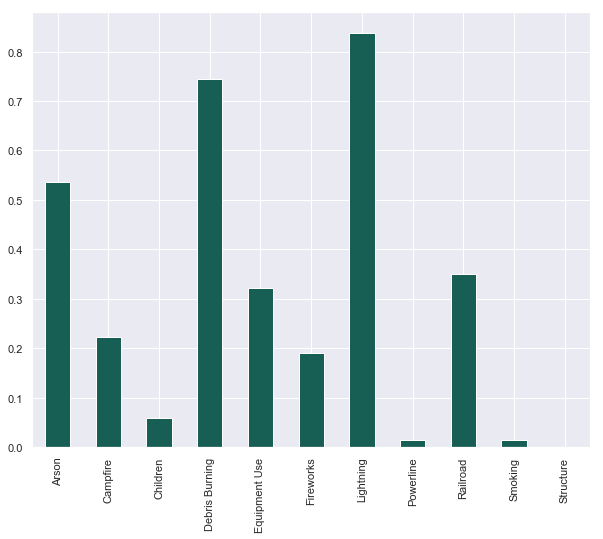

In [92]:
stats = breakdown.accuracy_breakdown(Y_test, Ypred_test)
stats.filter(items=['recall', 'precision']).plot(kind='bar')

### Confusion Matrix

It'd be nice to get a feel for how well the model is doing on each of the 11 categories. First, we need the predicted values:

In [ ]:
ypred = model.predict(normalized_data.values)

In [ ]:
confusion_mtx = sklearn.metrics.confusion_matrix(
    np.argmax(labels, axis=1),
    np.argmax(ypred, axis=1))

sns.set()
plt.figure(figsize=(10, 10))
sns.heatmap(np.log(confusion_mtx + 1))#, annot=True, fmt=".2f")

## Sklearn *k*-NN Oracle

Here we run *k*-NN for the training data, for use as an oracle, a target for our MLP to shoot for.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### *k* = 10

*k* = 10 should give okay but not great results.

In [ ]:
knn10 = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn10.fit(normalized_data, labels)

In [ ]:
y_pred = knn.predict(data)

Let's take a peek at the balanced accuracy for `k=10`:

In [ ]:
balanced_accuracy(labels, y_pred)

### *k* = 5

*k* = 5 should be a little better.

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn2.fit(data, labels)

In [ ]:
ypred2 = knn2.predict(data)

In [ ]:
balanced_accuracy(labels, ypred2)

### *k* = 3

Now we're starting to approach *k* = 1, which is by definition 100% accurate, so we expect to continue to see the accuracy rise.

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn3.fit(data, labels)

In [ ]:
y_pred3 = knn3.predict(data)

In [ ]:
balanced_accuracy(labels, y_pred3)

## UMAP

In [93]:
import umap

In [94]:
reducer = umap.UMAP()

In [109]:
UMAP_COLS = """
fire_size
fire_year
discovery_date
burn_time
burn_time_notna
latitude
longitude
""".strip().split("\n")

Xsamp = X_train.sample(frac=0.05)
Ysamp = Y_train.loc[Xsamp.index]
Xsamp = Xsamp.filter(items=UMAP_COLS)

In [110]:
embedding = reducer.fit_transform(Xsamp)

/Users/sjespersen/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 32 separate connected components using meta-embedding (experimental)
  n_components


In [146]:
len(Xsamp)

62564

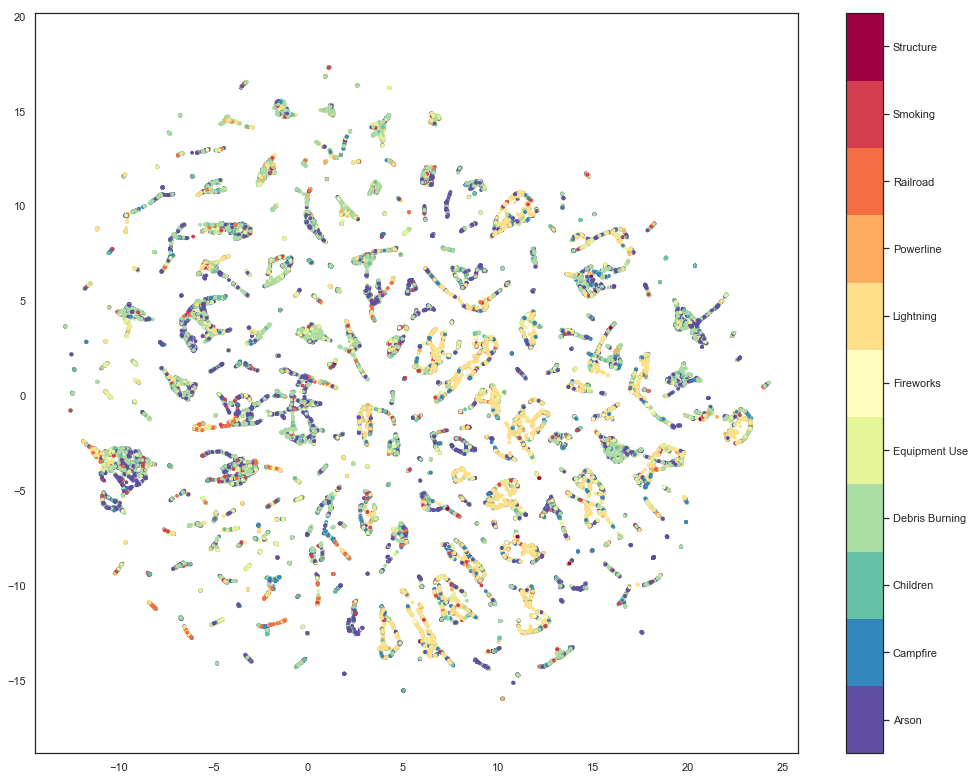

In [145]:
plt.figure(figsize=(14,11))
sns.set(style='white')
plt.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(Ysamp.values, axis=1), cmap='Spectral_r', s=8)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(boundaries=np.arange(12)-0.5)
cbar.set_ticks(np.arange(11))
cbar.set_ticklabels(Ysamp.columns)
plt.tight_layout()